##Introduction

After a hurrican in populated as well as sparse areas of human settlements, the very next thing after human rescue is the damage assessment. This is very critical for emergence managers as it helps them in efficint response and proper resource allocation. The only way for doing this is using ground survey or drones to manually quantify the number of flooded or damaged buildings. But this process being highly labour intensive and time taking, other efficint and faster methods have to be developed.

Having access to satellite imagery, its capabilities can easily be harnessed for this task. We can take satellite images of hurricane damaged areas, extract square size images containing one or group of buildings (using building coordinates) and use those square images to train a neural netwrok which can easily predict which building is damaged and which is not, how many buildings in a locality is damaged, etc. for any new satellite images of a particular area. This method will be cost efficint, easier and way faster and will help emergency managers accurately plan the resource requirement and efficiently distribute resources to those in need.
In this notebook, we have used the square images of buildings in hurricane hit areas (which has been already extracted from satellite images) to train our model, to see how much accurate a deep learning model can be in classifying damaged and not-damaged buildings, and drawing inferences as to whether this method can be used in the post-hurricane emergency situation.

Our main focus in this notebook is to see how different SOTA models perform on the given dataset for the task of classification, compare them with our custom built model and understand which part of the image any CNN model usually focusses on to be able to classify it as damaged or not-damaged.

Following is the broader description of the work carried out in this notebook:

1.Creating an image data pipeline: To access images as datasets, do necessary transformations and prefetching for optimal utilization computing resourses.

2.Building model architecture: Creating layer by layer whole CNN network in case of custom model or importing a SOTA model, customizing it and compiling it 
on MultiOptimizer.

3.Training of model using the dataset

4.Extracting inferences and comparison of model performaces: For both balanced and unbalanced test sets.

5.Visualzing which part of the image model uses to make its prediction: Using both Saliency Mapping and GradCam.



*Importing required libraries for the project*

In [ ]:
import h5py
import PIL.Image
import os, shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
from keras.regularizers import l2
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Unzipping the content from the drive and storing it on the colab in post_hurricane folder*

In [ ]:
!unzip /content/drive/MyDrive/Post-hurricane.zip -d post_hurricane

Streaming output truncated to the last 5000 lines.
  inflating: post_hurricane/train_another/no_damage/-95.647227_29.836576.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647465_29.833225.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647467_29.832897999999997.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647548_29.840203000000002.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647552_29.838818.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647554_29.839122999999997.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647554_29.839263.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647575_29.838532.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647581_29.838371999999996.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647581_29.839594.jpeg  
  inflating: post_hurricane/train_another/no_damage/-95.647723_29.837940000000003.jpeg  
  inflating: post_hurric

In [ ]:
input_path = '/content/post_hurricane'

*Checking if the files have been imported correctly and the size is correct*

In [ ]:
def print_file_sizes(input_path, subset):
  print('{}:'.format(subset))
  print('')
  path = input_path + subset + '/'
  for f in os.listdir(path):
    if not os.path.isdir(path + f):
      print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
    else:
      sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
      print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
  print('')
    
print_file_sizes(input_path, '/train_another')
print_file_sizes(input_path, '/validation_another')
print_file_sizes(input_path, '/test_another')
print_file_sizes(input_path, '/test')

/train_another:

no_damage                     15.07MB (5000 files)
damage                        12.56MB (5000 files)
.DS_Store                     0.01MB

/validation_another:

no_damage                     3.02MB (1000 files)
damage                        2.52MB (1000 files)

/test_another:

no_damage                     3.01MB (1000 files)
damage                        20.12MB (8000 files)

/test:

no_damage                     2.99MB (1000 files)
damage                        2.53MB (1000 files)
.DS_Store                     0.01MB



*Extracting all the files from the folder post_hurricane and saving it in the pandas dataframe*

In [ ]:
image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string
image_df.head()


,path,damage,data_split,location,lon,lat
0,/content/post_hurricane/validation_another/no_...,no_damage,validation_another,-95.635334_29.853915,-95.635334,29.853915
1,/content/post_hurricane/validation_another/no_...,no_damage,validation_another,-95.63551700000001_29.844526000000002,-95.635517,29.844526
2,/content/post_hurricane/validation_another/no_...,no_damage,validation_another,-95.242592_30.026562,-95.242592,30.026562
3,/content/post_hurricane/validation_another/no_...,no_damage,validation_another,-95.638593_29.771083,-95.638593,29.771083
4,/content/post_hurricane/validation_another/no_...,no_damage,validation_another,-95.09656700000001_29.844895,-95.096567,29.844895


*Plotting the train and validation split and the labels in the graph.*

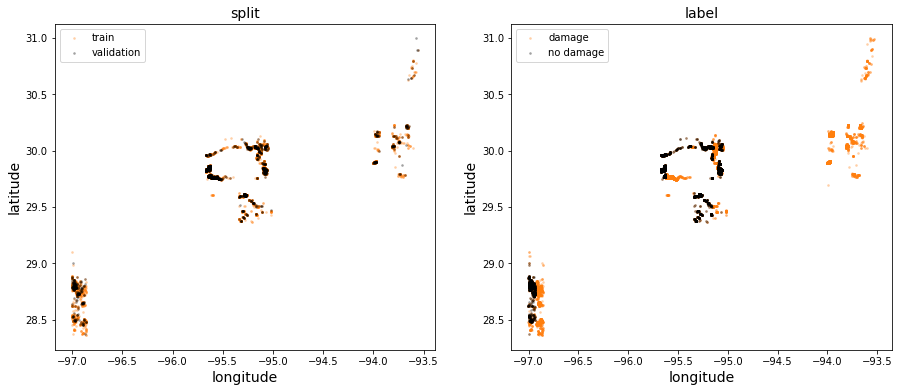

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

s = 3
alpha = 0.25

# get the train-validation-test splits
image_df_train = image_df[image_df['data_split']=='train_another'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test_another'].copy()

# sort to ensure reproducible behaviour
image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C1', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='k', s=s, alpha=alpha, label='validation')

ax[0].set_title('split', fontsize=14)
ax[0].legend()
ax[0].set_xlabel('longitude', fontsize=14)
ax[0].set_ylabel('latitude', fontsize=14)

image_df_dmg = image_df[image_df['damage']=='damage'].copy()
image_df_nodmg = image_df[image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C1', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')

ax[1].set_title('label', fontsize=14)
ax[1].legend()
ax[1].set_xlabel('longitude', fontsize=14)
ax[1].set_ylabel('latitude', fontsize=14)

plt.show(fig)

*Inference -  This plot gives us the inference that the building near the longitude -  -93.5 are greatly affected and most of them have suffered damage from hurricane*

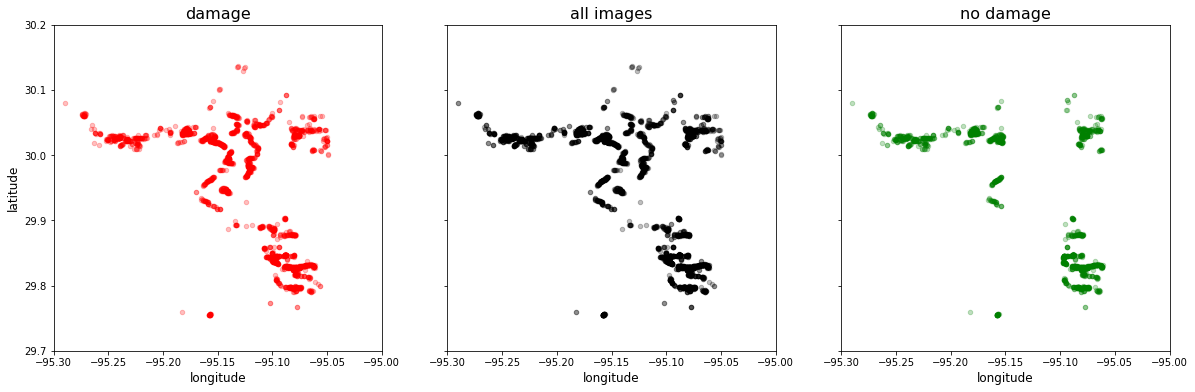

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True, sharey=True)

s = 20
alpha = 0.25

ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='Red', s=s, alpha=alpha, label='damage')
ax[0].set_title('damage', fontsize=16)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='k', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')
ax[1].set_title('all images', fontsize=16)

ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='Green', s=s, alpha=alpha, label='no damage')
ax[2].set_title('no damage', fontsize=16)

ax[0].set_ylabel('latitude', fontsize = 12)
ax[0].set_xlabel('longitude', fontsize = 12)
ax[1].set_xlabel('longitude', fontsize = 12)
ax[2].set_xlabel('longitude', fontsize = 12)

ax[0].set_xlim(-95.3,-95)
ax[0].set_ylim(29.7,30.2)

plt.show(fig)

*Inference - From this graph we can note that most of the building in the region of longitude - (-95.15 to -95.10) have suffered damage from the hurricane*

*Zooming in on the left group*

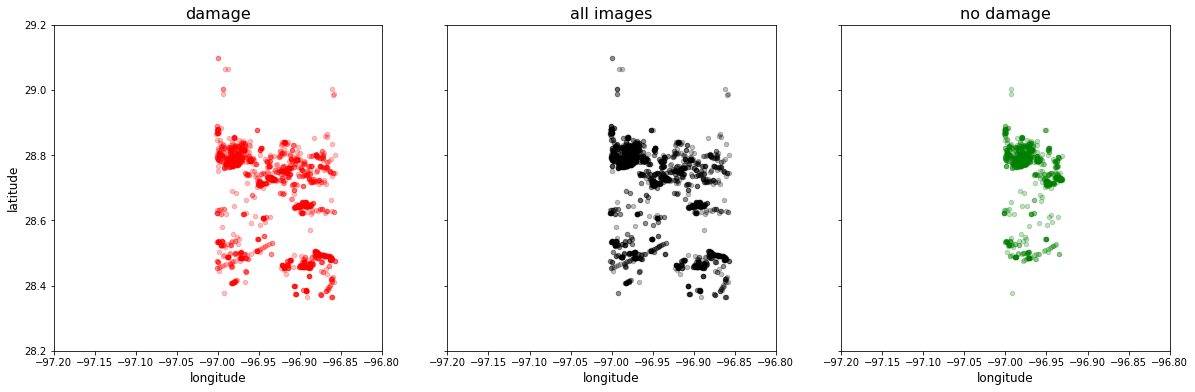

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True, sharey=True)

s = 20
alpha = 0.25

ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='Red', s=s, alpha=alpha, label='damage')
ax[0].set_title('damage', fontsize=16)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='k', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')
ax[1].set_title('all images', fontsize=16)

ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='Green', s=s, alpha=alpha, label='no damage')
ax[2].set_title('no damage', fontsize=16)

ax[0].set_ylabel('latitude', fontsize = 12)
ax[0].set_xlabel('longitude', fontsize = 12)
ax[1].set_xlabel('longitude', fontsize = 12)
ax[2].set_xlabel('longitude', fontsize = 12)

ax[0].set_xlim(-97.2,-96.8)
ax[0].set_ylim(28.2,29.2)

plt.show(fig)

*Inference - From this graph we can note that most of the building in the region of longitude - (-96.90 to -96.85) have suffered damage from the hurricane*

*Zooming in on the right group*

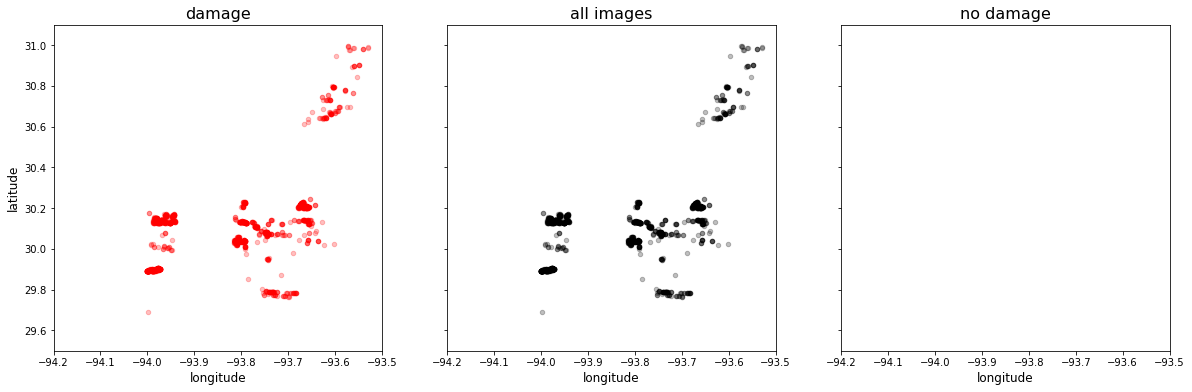

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True, sharey=True)

s = 20
alpha = 0.25

ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='Red', s=s, alpha=alpha, label='damage')
ax[0].set_title('damage', fontsize=16)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='k', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')
ax[1].set_title('all images', fontsize=16)

ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='Green', s=s, alpha=alpha, label='no damage')
ax[2].set_title('no damage', fontsize=16)

ax[0].set_ylabel('latitude', fontsize = 12)
ax[0].set_xlabel('longitude', fontsize = 12)
ax[1].set_xlabel('longitude', fontsize = 12)
ax[2].set_xlabel('longitude', fontsize = 12)

ax[0].set_xlim(-94.2,-93.5)
ax[0].set_ylim(29.5,31.1)

plt.show(fig)

*Inference - From this graph we can note that all the buldings in this group have suffered damage from the hurricane*

In [ ]:
img = cv2.imread(image_df['path'][0], cv2.IMREAD_UNCHANGED)
np.shape(img)

(128, 128, 3)

*Plotting some images from the damage and no damage*

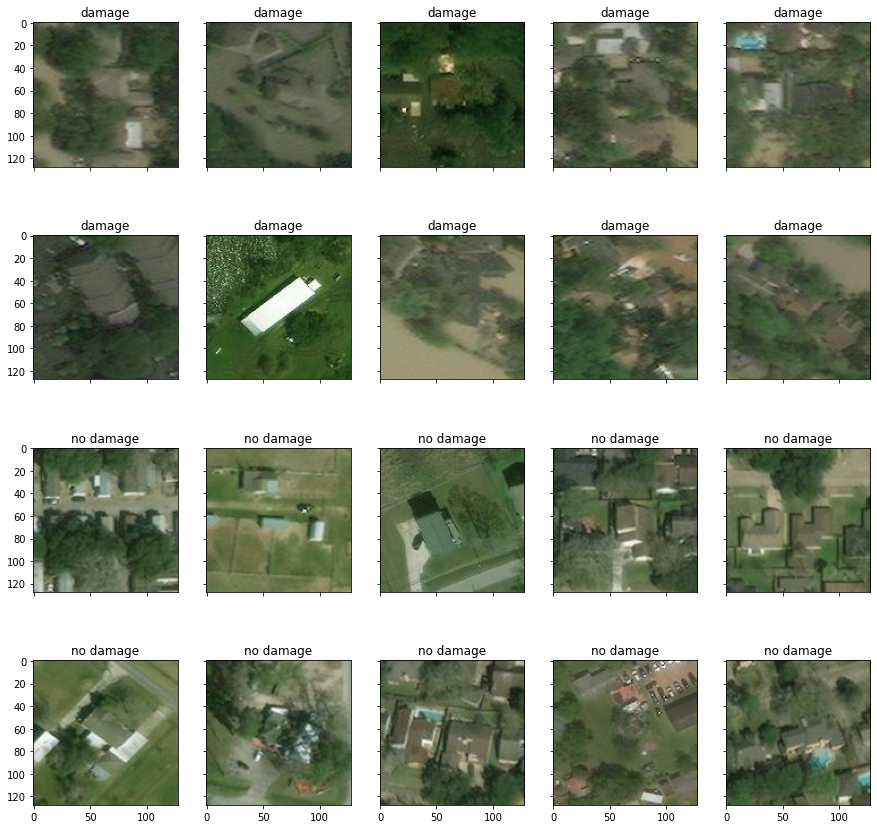

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, figsize=(15,15))
ax = ax.flatten()
for i in range(10):
  img = cv2.imread(image_df_dmg['path'][i], cv2.IMREAD_UNCHANGED)
  ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[i].set_title('damage')
    
for i in range(10,20):
  img = cv2.imread(image_df_nodmg['path'][i], cv2.IMREAD_UNCHANGED)
  ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[i].set_title('no damage')
    
plt.show()

In [ ]:
dataset_dir = '/content/post_hurricane'
train_damage_dir = '/content/post_hurricane/train_another/damage'
validation_damage_dir = '/content/post_hurricane/validation_another/damage'
test_damage_dir = '/content/post_hurricane/test_another/damage'

train_nodamage_dir = '/content/post_hurricane/train_another/no_damage'
validation_nodamage_dir = '/content/post_hurricane/validation_another/no_damage'
test_nodamage_dir = '/content/post_hurricane/test_another/no_damage'

In [ ]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))
print("======================================")
print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  8000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [ ]:
#train using transfer learning and data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, vertical_flip = True, horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented
train_generator = train_datagen.flow_from_directory('/content/post_hurricane/train_another', target_size = (150,150), batch_size = 32, class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory('/content/post_hurricane/validation_another', target_size = (150,150), batch_size = 32, class_mode = 'binary')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/post_hurricane/test', target_size = (150,150), batch_size = 20, class_mode = 'binary') #balanced test set
test_another_datagen = ImageDataGenerator(rescale=1./255)
test_another_generator = test_another_datagen.flow_from_directory('/content/post_hurricane/test_another', target_size = (150,150), batch_size = 20, class_mode = 'binary') #Unbalanced test set 
#Callback for early stopping
callback = EarlyStopping(
    monitor='val_accuracy', patience=10, mode='auto',
    baseline=None, restore_best_weights=True)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


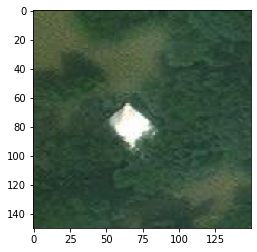

In [ ]:
img_path = '/content/post_hurricane/train_another/damage/-93.55964_30.895018.jpeg'
img = image.load_img(img_path, target_size = (150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()

##CNN Model with RGB Scale

In [ ]:
CNN_model = Sequential()

CNN_model.add(Conv2D(32, (3,3), activation='relu',padding='same', input_shape=(128,128,3)))
CNN_model.add(MaxPooling2D((2, 2),strides=2,padding='same'))
CNN_model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
CNN_model.add(MaxPooling2D((2, 2),strides=2,padding='same'))

CNN_model.add(Conv2D(128, (3,3), activation='relu',padding='same', input_shape=(128,128,3)))
CNN_model.add(MaxPooling2D((2, 2),strides=2,padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu',padding='same'))
CNN_model.add(MaxPooling2D((2, 2),strides=2,padding='same'))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(64, activation='relu'))

CNN_model.add(Dense(1,activation='sigmoid'))
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
CNN_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
callback = EarlyStopping(patience=10,monitor='accuracy')
history = CNN_model.fit(train_datagen,steps_per_epoch=100,validation_data=val_datagen,validation_steps=10,epochs=100,callbacks=callback)

Epoch 1/100
100/100 [==============================] - 17s 156ms/step - loss: 0.6832 - accuracy: 0.5394 - val_loss: 0.6454 - val_accuracy: 0.5250
Epoch 2/100
100/100 [==============================] - 16s 155ms/step - loss: 0.5732 - accuracy: 0.7236 - val_loss: 0.5039 - val_accuracy: 0.7688
Epoch 3/100
100/100 [==============================] - 16s 156ms/step - loss: 0.4900 - accuracy: 0.7794 - val_loss: 0.5120 - val_accuracy: 0.7688
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 0.4348 - accuracy: 0.8184 - val_loss: 0.4119 - val_accuracy: 0.8156
Epoch 5/100
100/100 [==============================] - 16s 155ms/step - loss: 0.3974 - accuracy: 0.8345 - val_loss: 0.3022 - val_accuracy: 0.8687
Epoch 6/100
100/100 [==============================] - 17s 166ms/step - loss: 0.3231 - accuracy: 0.8700 - val_loss: 0.3004 - val_accuracy: 0.8906
Epoch 7/100
100/100 [==============================] - 15s 154ms/step - loss: 0.3151 - accuracy: 0.8806 - val_loss: 0.2880 -

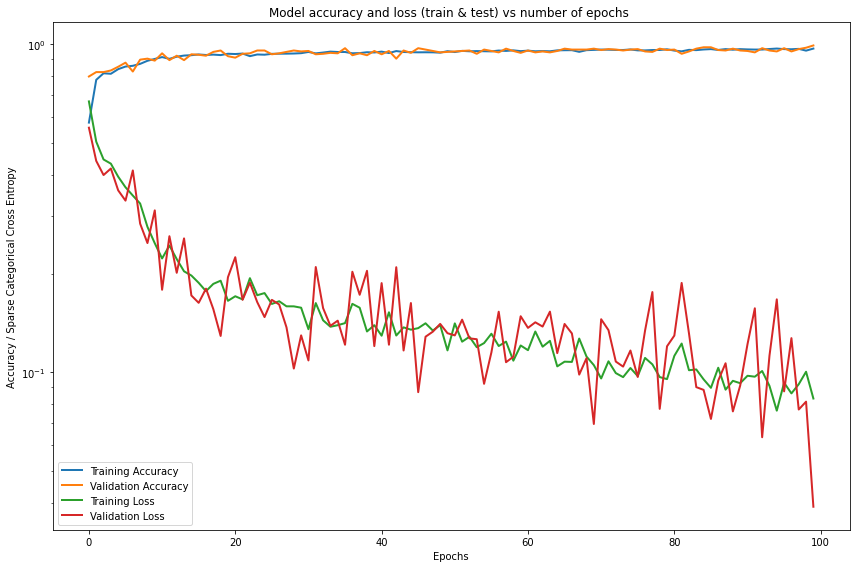

In [ ]:
#Plotting the accuracy and the loss of the model with respect to the number of epochs

# plotting train and val acc as  a function of epochs and 
# plotting train and val loss as  a function of epochs
plt.figure(figsize= (12,8))
plt.title("Model accuracy and loss (train & test) vs number of epochs ")
plt.semilogy(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.semilogy(history.history['val_accuracy'],  label='Validation Accuracy', linewidth=2)
plt.semilogy(history.history['loss'], label='Training Loss', linewidth=2)
plt.semilogy(history.history['val_loss'],  label='Validation Loss', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Sparse Categorical Cross Entropy')
plt.tight_layout()


*Saving the weights and printing out train and test accuracy*

In [ ]:
#CNN_model.save_weights('CNN.h5')
CNN_model.load_weights('CNN.h5')


In [ ]:
print("Model train accuracy : ",CNN_model.evaluate(train_datagen,steps=50,verbose=0)[1])
print("Model test accuracy : ",CNN_model.evaluate(test_datagen,steps=50,verbose=0)[1])

Model train accuracy :  0.9606249928474426
Model test accuracy :  0.9737499952316284


In [ ]:
#unbalanced data
print("Model train accuracy : ",CNN_model.evaluate(train_datagen,steps=100,verbose=0)[1])
print("Model test accuracy : ",CNN_model.evaluate(test_another_datagen,steps=100,verbose=0)[1])

Model train accuracy :  0.964062511920929
Model test accuracy :  0.956250011920929


In [ ]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(input_image)

In [ ]:
#setting layer number and input image id
layer_id = 1

idx = 10

In [ ]:
import random
#getting random file from test_another
img_path1 = glob(f'./test_another/'+ labels[0] +'/*.jpeg')
img_path2 = glob(f'./test_another/'+ labels[1] +'/*.jpeg')

img_path  = img_path1 + img_path2
random.shuffle(img_path)
label = img_path[0].split('/')[2]
img = image.load_img(img_path[0])
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [ ]:
# getting feature maps of specific layer

feature_maps = get_feature_maps(CNN_model,layer_id, img_tensor)


In [ ]:
#shape of the feature_maps array
feature_maps.shape

(1, 64, 64, 32)

*Plotting feature map of a random image*

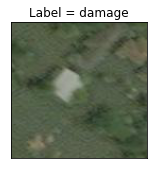

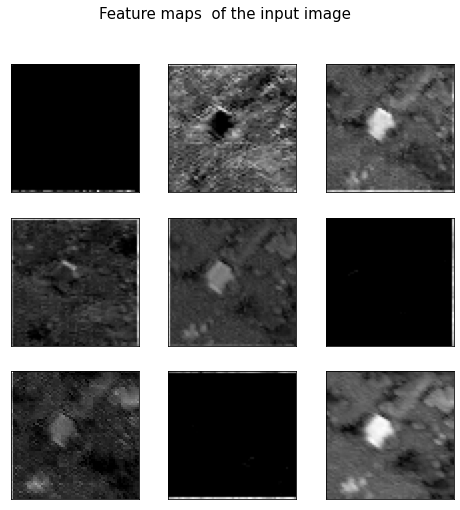

In [ ]:

#plotting the image
plt.figure(figsize=(2.5,2.5))
plt.imshow(img_tensor[0])
plt.title(f"Label = {label}")
plt.xticks([])
plt.yticks([])
plt.show()
print()

#plotting the feature maps
j = feature_maps.shape[3] - 1 

fig,ax = plt.subplots(3,3,figsize=(8,8))
axs = ax.ravel()
fig.suptitle("Feature maps  of the input image",size=15)
for i in range(9):
  img = feature_maps[0,:,:,j- i]
  axs[i].imshow(img,cmap='gray')
  axs[i].set_xticks([])
  axs[i].set_yticks([])
plt.show()

*Plotting saliency and gradcam for a predicted image*

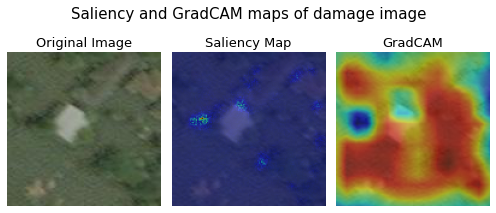

In [ ]:
"""
https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html
https://pypi.org/project/tf-keras-vis/
Which visualization is easier to understand in your case, and what does the network seem to be focusing on?
"""
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore


replace2linear = ReplaceToLinear()
score = BinaryScore(labels.index(label))


saliency = Saliency(CNN_model,
                    model_modifier=replace2linear,
                    clone=True)

#generating saliency map
saliency_map = saliency(score,img_tensor[0])


gradcam = Gradcam(CNN_model,
                  model_modifier=replace2linear,
                  clone=True)
cam = gradcam(score,
              img_tensor[0],
              penultimate_layer=-1)
cam = normalize(cam)
#generating heatmap
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)




fig,ax = plt.subplots(1,3,figsize=(7,5))

#original image
ax[0].imshow(img_tensor[0])
ax[0].axis('off')
ax[0].set_title("Original Image",size=13)

#saliency map
ax[1].imshow(img_tensor[0])
ax[1].imshow(saliency_map[0],cmap='jet',alpha=0.5)
ax[1].axis('off')
ax[1].set_title("Saliency Map",size=13)


#GradCAM
ax[2].imshow(img_tensor[0])
ax[2].imshow(heatmap[0],cmap='jet',alpha=0.5)
ax[2].axis('off')
ax[2].set_title("GradCAM",size=13)

fig.text(0.5,0.82,f"Saliency and GradCAM maps of {label} image",size=15,ha='center',va='center')

fig.tight_layout()



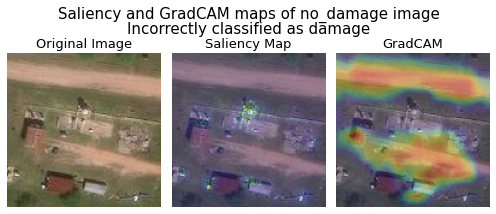

In [ ]:
#index of the first incorectly classified image
for i in range(200,len(img_path)):
  label = img_path[i].split('/')[2]
  img = image.load_img(img_path[i])
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  pred = CNN_model.predict(img_tensor).round()
  if labels[int(pred[0][0])]!=label:
    break

  

#maps

replace2linear = ReplaceToLinear()
score = BinaryScore(label)


saliency = Saliency(CNN_model,
                    model_modifier=replace2linear,
                    clone=True)

#generating saliency map
saliency_map = saliency(score, img_tensor[0])


gradcam = Gradcam(CNN_model,
                  model_modifier=replace2linear,
                  clone=True)
cam = gradcam(score,
              img_tensor[0],
              penultimate_layer=-1)
cam = normalize(cam)
#generating heatmap
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)




fig,ax = plt.subplots(1,3,figsize=(7,5))

#original image
ax[0].imshow(img_tensor[0])
ax[0].axis('off')
ax[0].set_title("Original Image",size=13)

#saliency map
ax[1].imshow(img_tensor[0])
ax[1].imshow(saliency_map[0],cmap='jet',alpha=0.25)
ax[1].axis('off')
ax[1].set_title("Saliency Map",size=13)


#GradCAM
ax[2].imshow(img_tensor[0])
ax[2].imshow(heatmap[0],cmap='jet',alpha=0.25)
ax[2].axis('off')
ax[2].set_title("GradCAM",size=13)

fig.text(0.5,0.82,f"Saliency and GradCAM maps of {label} image",size=15,ha='center',va='center')
fig.text(0.5,0.78,f"Incorrectly classified as {labels[int(pred[0][0])]}",size=15,ha='center',va='center')

fig.tight_layout()



##CNN Model with Grayscale image

In [ ]:

datagen = ImageDataGenerator(rescale=1./255,rotation_range=180,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
batch_size = 32
target_size = (128,128)
train_DIR = './train_another'
test_DIR = './test_another'
validation_DIR = './validation_another'

traingen_gr = datagen.flow_from_directory(directory=train_DIR,class_mode="binary",target_size=target_size,batch_size=batch_size,shuffle=True,color_mode ="grayscale")

valgen_gr = datagen.flow_from_directory(directory=validation_DIR,class_mode="binary",target_size=target_size,batch_size=batch_size,shuffle=True,color_mode ="grayscale")
 
testgen_gr = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_DIR,class_mode="binary",target_size=target_size,batch_size=batch_size,shuffle=False,color_mode ="grayscale")

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


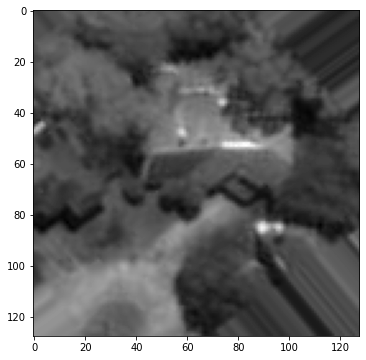

In [ ]:
#plot an image from the traingen_gr
plt.imshow((traingen_gr.next()[0][0]).squeeze(axis=2),cmap='gray')
plt.show()

In [ ]:
CNN_model_gr = Sequential()

CNN_model_gr.add(Conv2D(32, (3,3), activation='relu',padding='same', input_shape=(128,128,1)))
CNN_model_gr.add(MaxPooling2D((2, 2),strides=2,padding='same'))
CNN_model_gr.add(Conv2D(64, (3,3), activation='relu',padding='same'))
CNN_model_gr.add(MaxPooling2D((2, 2),strides=2,padding='same'))

CNN_model_gr.add(Conv2D(128, (3,3), activation='relu',padding='same'))
CNN_model_gr.add(MaxPooling2D((2, 2),strides=2,padding='same'))
CNN_model_gr.add(Conv2D(128, (3,3), activation='relu',padding='same'))
CNN_model_gr.add(MaxPooling2D((2, 2),strides=2,padding='same'))

CNN_model_gr.add(Flatten())
CNN_model_gr.add(Dense(512, activation='relu'))
CNN_model_gr.add(Dense(128, activation='relu'))
CNN_model_gr.add(Dense(64, activation='relu'))

CNN_model_gr.add(Dense(1,activation='sigmoid'))
CNN_model_gr.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 128)     

In [ ]:
CNN_model_gr.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
callback = EarlyStopping(patience=10,monitor='val_accuracy')
history = CNN_model_gr.fit(traingen_gr,steps_per_epoch=100,validation_data=valgen_gr,validation_steps=10,epochs=100,callbacks=callback)

Epoch 1/100
100/100 [==============================] - 8s 76ms/step - loss: 0.6622 - accuracy: 0.5726 - val_loss: 0.6357 - val_accuracy: 0.5688
Epoch 2/100
100/100 [==============================] - 7s 73ms/step - loss: 0.5219 - accuracy: 0.7675 - val_loss: 0.5329 - val_accuracy: 0.7719
Epoch 3/100
100/100 [==============================] - 7s 73ms/step - loss: 0.4677 - accuracy: 0.8109 - val_loss: 0.4863 - val_accuracy: 0.7875
Epoch 4/100
100/100 [==============================] - 7s 73ms/step - loss: 0.4383 - accuracy: 0.8181 - val_loss: 0.4266 - val_accuracy: 0.8188
Epoch 5/100
100/100 [==============================] - 7s 74ms/step - loss: 0.4275 - accuracy: 0.8238 - val_loss: 0.3791 - val_accuracy: 0.8250
Epoch 6/100
100/100 [==============================] - 7s 74ms/step - loss: 0.3776 - accuracy: 0.8417 - val_loss: 0.3828 - val_accuracy: 0.8656
Epoch 7/100
100/100 [==============================] - 9s 89ms/step - loss: 0.3893 - accuracy: 0.8344 - val_loss: 0.3909 - val_accuracy:

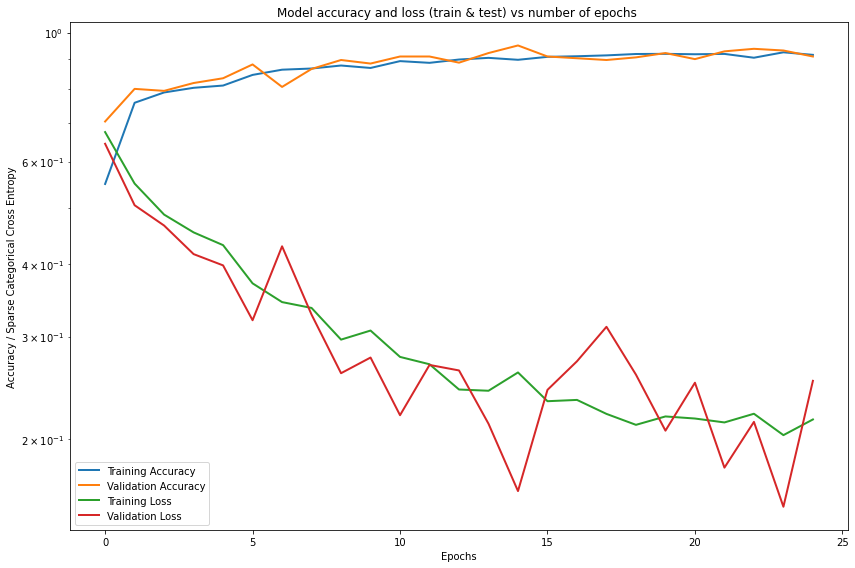

In [ ]:
#Plotting the accuracy and the loss of the model with respect to the number of epochs

# plotting train and val acc as  a function of epochs and 
# plotting train and val loss as  a function of epochs
plt.figure(figsize= (12,8))
plt.title("Model accuracy and loss (train & test) vs number of epochs ")
plt.semilogy(history1.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.semilogy(history1.history['val_accuracy'],  label='Validation Accuracy', linewidth=2)
plt.semilogy(history1.history['loss'], label='Training Loss', linewidth=2)
plt.semilogy(history1.history['val_loss'],  label='Validation Loss', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Sparse Categorical Cross Entropy')
plt.tight_layout()



In [ ]:
#CNN_model_gr.save_weights('CNN_gr.h5')
CNN_model_gr.load_weights('CNN_gr.h5')


In [ ]:
#balanced data
testgen2_gr = ImageDataGenerator(rescale=1./255).flow_from_directory(directory='./test',class_mode="binary",target_size=target_size,batch_size=batch_size,shuffle=False,color_mode ="grayscale")

Found 2000 images belonging to 2 classes.


In [ ]:
print("Model train accuracy : ",CNN_model_gr.evaluate(traingen_gr,steps=50,verbose=0)[1])
print("Model test accuracy : ",CNN_model_gr.evaluate(testgen2_gr,steps=50,verbose=0)[1])

Model train accuracy :  0.9156249761581421
Model test accuracy :  0.8968750238418579


In [ ]:
#unbalanced data
print("Model train accuracy : ",CNN_model_gr.evaluate(traingen_gr,steps=100,verbose=0)[1])
print("Model test accuracy : ",CNN_model_gr.evaluate(testgen_gr,steps=100,verbose=0)[1])

Model train accuracy :  0.9190624952316284
Model test accuracy :  0.7215625047683716


##Transfer Learning

**With Original images**

In [ ]:
#defining the file path
train_path='/content/post_hurricane/train_another'

test_path='/content/post_hurricane/test'

val_path='/content/post_hurricane/validation_another'

test_un_path= '/content/post_hurricane/test_another'

#defining a Data Generator class object

train= ImageDataGenerator(rescale=1./255, rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
                                 vertical_flip=True, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.2,1.0])
test= ImageDataGenerator(rescale=1./255, rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
                                 vertical_flip=True, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.2,1.0])
val= ImageDataGenerator(rescale=1./255, rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
                                 vertical_flip=True, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.2,1.0])

In [ ]:
train_images = train.flow_from_directory(
    train_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 10000 images belonging to 2 classes.


In [ ]:
val_images = val.flow_from_directory(
    val_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 2000 images belonging to 2 classes.


In [ ]:
test_images = test.flow_from_directory(
    test_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 2000 images belonging to 2 classes.


In [ ]:
test_un_images = test.flow_from_directory(
    test_un_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 9000 images belonging to 2 classes.


In [ ]:
base_model=DenseNet121(weights='imagenet',include_top=False) # imports the densenet model and discards the last 1000 neuron layer.
 
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x) #add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(128,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(64,activation='relu')(x) #dense layer 3
x=tf.keras.layers.Dropout(0.5)(x)
preds=tf.keras.layers.Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation
 
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers:
    layer.trainable=True
 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
history = model.fit(train_images,validation_data=val_images,batch_size=256,epochs=10)

Epoch 1/10
313/313 [==============================] - 1823s 6s/step - loss: 0.3073 - accuracy: 0.8768 - val_loss: 0.9950 - val_accuracy: 0.5035
Epoch 2/10
313/313 [==============================] - 202s 645ms/step - loss: 0.2021 - accuracy: 0.9255 - val_loss: 0.1568 - val_accuracy: 0.9365
Epoch 3/10
313/313 [==============================] - 211s 674ms/step - loss: 0.1713 - accuracy: 0.9357 - val_loss: 0.1997 - val_accuracy: 0.9275
Epoch 4/10
313/313 [==============================] - 203s 648ms/step - loss: 0.1404 - accuracy: 0.9499 - val_loss: 0.1604 - val_accuracy: 0.9455
Epoch 5/10
313/313 [==============================] - 204s 650ms/step - loss: 0.1380 - accuracy: 0.9496 - val_loss: 0.2857 - val_accuracy: 0.9345
Epoch 6/10
313/313 [==============================] - 202s 646ms/step - loss: 0.1301 - accuracy: 0.9517 - val_loss: 0.1110 - val_accuracy: 0.9515
Epoch 7/10
313/313 [==============================] - 203s 647ms/step - loss: 0.1239 - accuracy: 0.9561 - val_loss: 0.1380 - v

In [ ]:
model.save('/content/gdrive/MyDrive/Data/transfer_learning_not_sharpened') #Saving the model

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Data/transfer_learning_not_sharpened/assets


In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/Data/transfer_learning_not_sharpened')   # loading the saved model

In [ ]:
model.summary()   #summary of the model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, None, None,   0          ['input_3[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_4[0][0]']       
                                64)                                                         

In [ ]:
#Evaluating accuracies

print("Model train accuracy : ",model.evaluate(train_images,steps=50,verbose=0)[1])
print("Model test accuracy : ",model.evaluate(test_images,steps=50,verbose=0)[1])  # on balanced test dataset

Model train accuracy :  0.9593750238418579
Model test accuracy :  0.9543750286102295


In [ ]:
#unbalanced test dataset
print("Model test accuracy : ",model.evaluate(test_un_images,steps=50,verbose=0)[1])

Model test accuracy :  0.9231250286102295


Text(0.5, 1.0, 'Loss Plot')

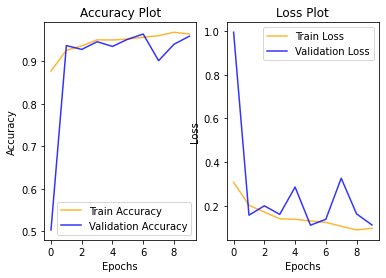

In [ ]:
#Plotting the training and validation accuracy and loss plots
from keras.callbacks import History
epochs_run = len(history.history['val_loss'])
fig, ax = plt.subplots(1,2)
ax[0].plot(range(epochs_run), history.history['accuracy'], color='orange', alpha=0.8, label='Train Accuracy')
ax[0].plot(range(epochs_run), history.history['val_accuracy'], color='blue', alpha=0.8, label='Validation Accuracy' )
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy Plot")

ax[1].plot(range(epochs_run), history.history['loss'], color='orange', alpha=1.8, label='Train Loss')
ax[1].plot(range(epochs_run), history.history['val_loss'], color='blue', alpha=1.8, label='Validation Loss' )
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss Plot")

**Visualization of the model results**

In [ ]:
#Creating tensor for visualization
import random
labels = ['damage','no_damage']
#getting random file from test_another
img_path1 = glob(f'/content/gdrive/MyDrive/Data/test_another/'+ labels[0] +'/*.jpeg')
img_path2 = glob(f'/content/gdrive/MyDrive/Data/test_another/'+ labels[1] +'/*.jpeg')

img_path  = img_path1 + img_path2
#random.shuffle(img_path)
label = img_path[1].split('/')[6]
img = image.load_img(img_path[1])
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

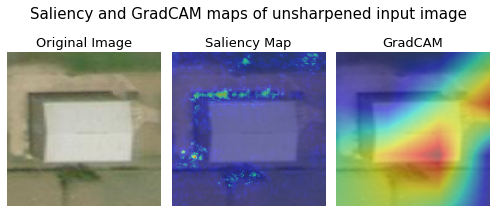

In [ ]:
# Visualization of model results using saliency and GradCAM

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore


replace2linear = ReplaceToLinear()
score = BinaryScore(labels.index(label))


saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

#generating saliency map
saliency_map = saliency(score,img_tensor[0])


gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)
cam = gradcam(score,
              img_tensor[0],
              penultimate_layer=-1)
cam = normalize(cam)
#generating heatmap
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)




fig,ax = plt.subplots(1,3,figsize=(7,5))

#original image
ax[0].imshow(img_tensor[0])
ax[0].axis('off')
ax[0].set_title("Original Image",size=13)

#saliency map
ax[1].imshow(img_tensor[0])
ax[1].imshow(saliency_map[0],cmap='jet',alpha=0.5)
ax[1].axis('off')
ax[1].set_title("Saliency Map",size=13)


#GradCAM
ax[2].imshow(img_tensor[0])
ax[2].imshow(heatmap[0],cmap='jet',alpha=0.5)
ax[2].axis('off')
ax[2].set_title("GradCAM",size=13)

fig.text(0.5,0.82,f"Saliency and GradCAM maps of unsharpened input image",size=15,ha='center',va='center')

fig.tight_layout()


##With sharpened images

In [ ]:
from PIL import Image
from PIL import ImageFilter

In [ ]:
#Sharpening the image and saving it in gdrive inside a folder named "sharpened" - /content/gdrive/MyDrive/Data/sharpened - will have sharpened images in the same folder names as below
#/content/gdrive/MyDrive/Data - is where the original train_another, validation_another, test_another, test is present
from tqdm import tqdm
if not os.path.isdir("/content/gdrive/MyDrive/Data/sharpened"):
  for r, d, f in tqdm(os.walk("/content/gdrive/MyDrive/Data")):
    for file_ in tqdm(f, leave=False):
      if "jpeg" in file_:
        image = Image.open(os.path.join(r,file_))
        sharpened = image.filter(ImageFilter.SHARPEN);
        os.makedirs(os.path.join("/content/gdrive/MyDrive/Data/sharpened", r.split("/")[-2], r.split("/")[-1]), exist_ok=True)
        sharpened.save(os.path.join("/content/gdrive/MyDrive/Data/sharpened", r.split("/")[-2], r.split("/")[-1], file_))

[]

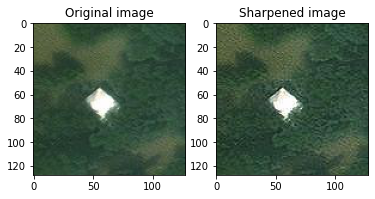

In [ ]:
#Plotting the original and sharpened image

fig, ax = plt.subplots(1,2)
ax[0].imshow(Image.open("/content/gdrive/MyDrive/Data/train_another/damage/-93.55964_30.895018.jpeg"))
ax[0].set_title("Original image")

ax[1].imshow(Image.open("/content/gdrive/MyDrive/Data/sharpened/train_another/damage/-93.55964_30.895018.jpeg"))
ax[1].set_title("Sharpened image")

plt.plot()

In [ ]:
#Image location of sharpened images

train_s_path='/content/gdrive/MyDrive/Data/sharpened/train_another'

test_s_path='/content/gdrive/MyDrive/Data/sharpened/test'

val_s_path='/content/gdrive/MyDrive/Data/sharpened/validation_another'

test_un_s_path= '/content/gdrive/MyDrive/Data/sharpened/test_another'

In [ ]:
train_s_images = train.flow_from_directory(
    train_s_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 10000 images belonging to 2 classes.


In [ ]:
val_s_images = val.flow_from_directory(
    val_s_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 2000 images belonging to 2 classes.


In [ ]:
test_s_images = test.flow_from_directory(
    test_s_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 2000 images belonging to 2 classes.


In [ ]:
test_un_s_images = test.flow_from_directory(
    test_un_s_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    seed=2020
)

Found 9000 images belonging to 2 classes.


In [ ]:
base_model=DenseNet121(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
 
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(128,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(64,activation='relu')(x) #dense layer 3
x=tf.keras.layers.Dropout(0.5)(x)
preds=tf.keras.layers.Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation
 
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers:
    layer.trainable=True
 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 

In [ ]:
#training model using sharpened images
history_sharpened = model.fit(train_s_images,validation_data=val_s_images,batch_size=256,epochs=10)

Epoch 1/10
313/313 [==============================] - 1042s 3s/step - loss: 0.2950 - accuracy: 0.8807 - val_loss: 2.1904 - val_accuracy: 0.5285
Epoch 2/10
313/313 [==============================] - 204s 650ms/step - loss: 0.1904 - accuracy: 0.9303 - val_loss: 0.3128 - val_accuracy: 0.8665
Epoch 3/10
313/313 [==============================] - 203s 648ms/step - loss: 0.1695 - accuracy: 0.9364 - val_loss: 0.3141 - val_accuracy: 0.8610
Epoch 4/10
313/313 [==============================] - 202s 645ms/step - loss: 0.1445 - accuracy: 0.9449 - val_loss: 0.6009 - val_accuracy: 0.7860
Epoch 5/10
313/313 [==============================] - 202s 644ms/step - loss: 0.1536 - accuracy: 0.9445 - val_loss: 0.1264 - val_accuracy: 0.9525
Epoch 6/10
313/313 [==============================] - 215s 687ms/step - loss: 0.1256 - accuracy: 0.9551 - val_loss: 0.3316 - val_accuracy: 0.9130
Epoch 7/10
313/313 [==============================] - 203s 648ms/step - loss: 0.1157 - accuracy: 0.9558 - val_loss: 0.1293 - v

In [ ]:
model.save('/content/gdrive/MyDrive/Data/transfer_learning_sharpened')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Data/transfer_learning_sharpened/assets


In [ ]:
model_sharpened = keras.models.load_model('/content/gdrive/MyDrive/Data/transfer_learning_sharpened')

In [ ]:
model_sharpened.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, None, None,   0          ['input_2[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_2[0][0]']       
                                64)                                                         

In [ ]:
print("Model train accuracy : ",model_sharpened.evaluate(train_s_images,steps=50,verbose=0)[1])
print("Model test accuracy : ",model_sharpened.evaluate(test_s_images,steps=50,verbose=0)[1])

Model train accuracy :  0.9393749833106995
Model test accuracy :  0.9318749904632568


In [ ]:
print("Model unbalanced test set accuracy : ",model_sharpened.evaluate(test_un_s_images,steps=50,verbose=0)[1])

Model unbalanced test set accuracy :  0.9725000262260437


Text(0.5, 1.0, 'Loss Plot')

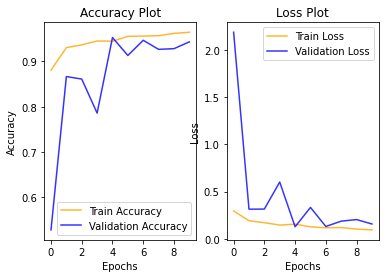

In [ ]:
#Plotting the training and validation accuracy and loss plots

epochs_run = len(history_sharpened.history['val_loss'])
fig, ax = plt.subplots(1,2)
ax[0].plot(range(epochs_run), history_sharpened.history['accuracy'], color='orange', alpha=0.8, label='Train Accuracy')
ax[0].plot(range(epochs_run), history_sharpened.history['val_accuracy'], color='blue', alpha=0.8, label='Validation Accuracy' )
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy Plot")

ax[1].plot(range(epochs_run), history_sharpened.history['loss'], color='orange', alpha=1.8, label='Train Loss')
ax[1].plot(range(epochs_run), history_sharpened.history['val_loss'], color='blue', alpha=1.8, label='Validation Loss' )
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss Plot")

In [ ]:
import random
labels = ['damage','no_damage']
#getting random file from test_another
img_path1 = glob(f'/content/gdrive/MyDrive/Data/sharpened/test_another/'+ labels[0] +'/*.jpeg')
img_path2 = glob(f'/content/gdrive/MyDrive/Data/sharpened/test_another/'+ labels[1] +'/*.jpeg')

img_path  = img_path1 + img_path2
#random.shuffle(img_path)
label = img_path[0].split('/')[7]
img = image.load_img('/content/gdrive/MyDrive/Data/test_another/damage/-95.669054_29.81782.jpeg')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

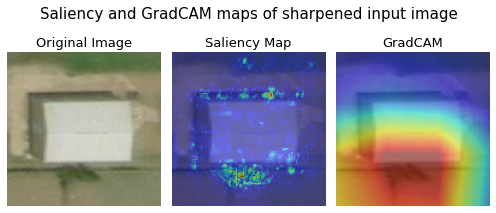

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore


replace2linear = ReplaceToLinear()
score = BinaryScore(labels.index(label))


saliency = Saliency(model_sharpened,
                    model_modifier=replace2linear,
                    clone=True)

#generating saliency map
saliency_map = saliency(score,img_tensor[0])


gradcam = Gradcam(model_sharpened,
                  model_modifier=replace2linear,
                  clone=True)
cam = gradcam(score,
              img_tensor[0],
              penultimate_layer=-1)
cam = normalize(cam)
#generating heatmap
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)




fig,ax = plt.subplots(1,3,figsize=(7,5))

#original image
ax[0].imshow(img_tensor[0])
ax[0].axis('off')
ax[0].set_title("Original Image",size=13)

#saliency map
ax[1].imshow(img_tensor[0])
ax[1].imshow(saliency_map[0],cmap='jet',alpha=0.5)
ax[1].axis('off')
ax[1].set_title("Saliency Map",size=13)


#GradCAM
ax[2].imshow(img_tensor[0])
ax[2].imshow(heatmap[0],cmap='jet',alpha=0.5)
ax[2].axis('off')
ax[2].set_title("GradCAM",size=13)

fig.text(0.5,0.82,f"Saliency and GradCAM maps of sharpened input image",size=15,ha='center',va='center')

fig.tight_layout()